In [0]:
!pip install tflearn
!pip install pydrive
!pip install matplotlib


    100% |████████████████████████████████| 102kB 3.6MB/s 
  Running setup.py bdist_wheel for tflearn ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fb/06/72/0478c938ca315c6fddcce8233b80ec91a115ce4496a27e8c90
Successfully built tflearn
    100% |████████████████████████████████| 993kB 1.1MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /content/.cache/pip/wheels/ea/bd/b1/14e948c56cce2c7ac1589346cb54d7efb659fa2ddfa6abba88
Successfully built pydrive


In [0]:
!pip install numpy==1.13.0

    100% |████████████████████████████████| 17.0MB 80kB/s 
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0


In [0]:
from __future__ import division, print_function, absolute_import

import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
test_pickle_filename='test.pkl'

In [0]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'1vQhQXjy4X9woILOTXeY3C-tz14xJkBQE' in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == test_pickle_filename:
     TESTPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))


title: test.pkl, id: 1gSKWAsH9YND3Y3_vNrXeXa-KRiPEGqBS


In [0]:
X_test = []
Y_test = []

label_pairs ={
    'adho_mukha_svanasana':1,
    'bharadvajasana':2,
    'pasasana':3,
    'salamba_sarvangasana':4,
    'salamba_sirsasana':5,
    'virabhadrasana_I':6,
    'virabhadrasana_II':7,
    'virabhadrasana_III':8
}

label_pairs_reverse ={
    1:'adho_mukha_svanasana',
    2:'bharadvajasana',
    3:'pasasana',
    4:'salamba_sarvangasana',
    5:'salamba_sirsasana',
    6:'virabhadrasana_I',
    7:'virabhadrasana_II',
    8:'virabhadrasana_III'
}

In [0]:
testFile = drive.CreateFile({'id': TESTPIK}).GetContentFile(test_pickle_filename)

In [0]:
!ls

datalab  test.pkl


In [0]:
X_type = 'float64'

with open(test_pickle_filename, "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 265


In [0]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [0]:
#Define Model
Y_test = to_categorical(Y_test, 9)

from __future__ import division, print_function, absolute_import

import tflearn

# Residual blocks
# 32 layers: n=5, 56 layers: n=9, 110 layers: n=18
n = 5

# Real-time data preprocessing
img_prep = tflearn.ImagePreprocessing()
#img_prep.add_featurewise_zero_center(per_channel=True)

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
#img_aug.add_random_flip_leftright()
#img_aug.add_random_blur()
#img_aug.add_random_crop([64, 64], padding=4)

# Building Residual Network
network = tflearn.input_data(shape=[None, 64, 64, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)
network = tflearn.conv_2d(network, 16, 3, regularizer='L2', weight_decay=0.0001)
network = tflearn.residual_block(network, n, 16)
network = tflearn.residual_block(network, 1, 32, downsample=True)
network = tflearn.residual_block(network, n-1, 32)
network = tflearn.residual_block(network, 1, 64, downsample=True)
network = tflearn.residual_block(network, n-1, 64)
network = tflearn.batch_normalization(network)
network = tflearn.activation(network, 'relu')
network = tflearn.global_avg_pool(network)
# Regression
network = tflearn.fully_connected(network, 9, activation='softmax')
mom = tflearn.Momentum(0.1, lr_decay=0.1, decay_step=32000, staircase=True)
network = tflearn.regression(network, optimizer=mom,
                         loss='categorical_crossentropy')


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
model_name = "resnet32_skeletal_insights"
# Auto-iterate through all files in the root folder.
model_parentfolder_id="1Ay8W74_15gHTpEz-SARe-mxXBE-yTKoe"
file_list = drive.ListFile({'q': "'{parent_id}'".format(parent_id=model_parentfolder_id) + " in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == model_name :
   model_dir = drive.ListFile({'q': "'{folderid}' in parents and trashed=false".format(folderid=file1['id'])}).GetList()
for file1 in file_list:
   for file2 in model_dir:
      drive.CreateFile({'id': file2['id']}).GetContentFile(file2['title']) 
   

In [0]:
model = tflearn.DNN(network)

In [0]:
model.load(model_name)

INFO:tensorflow:Restoring parameters from /content/resnet32_skeletal_insights


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


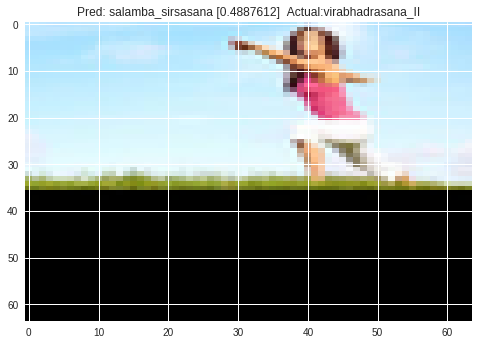

-------------------------------------------------------------------


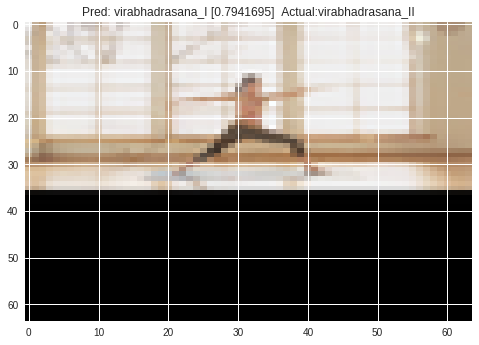

-------------------------------------------------------------------


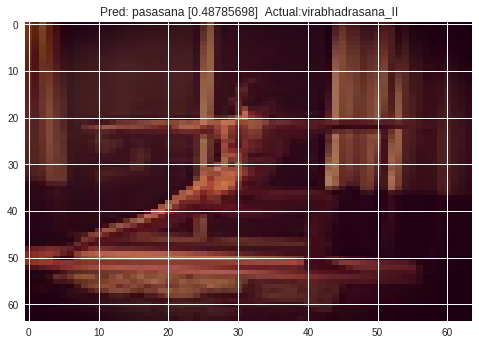

-------------------------------------------------------------------


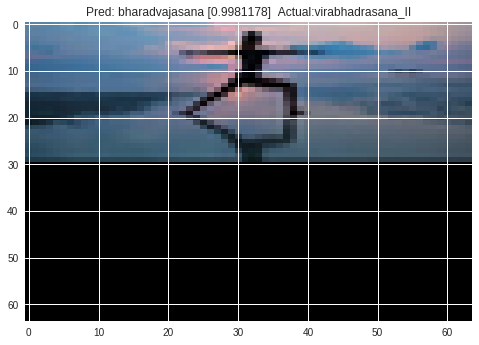

-------------------------------------------------------------------


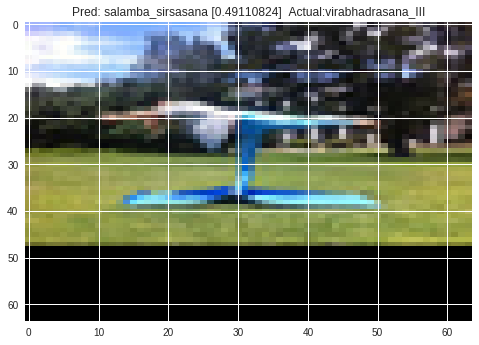

-------------------------------------------------------------------


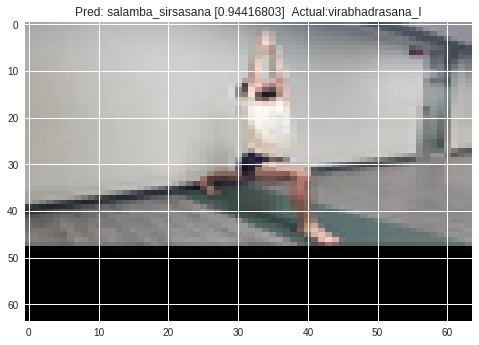

-------------------------------------------------------------------


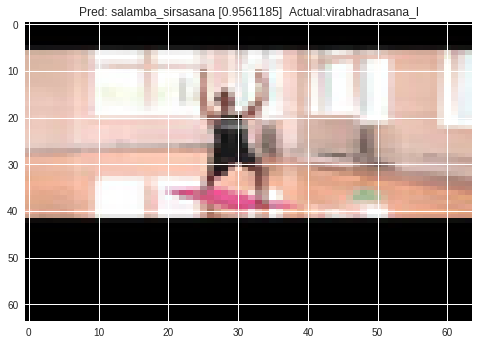

-------------------------------------------------------------------


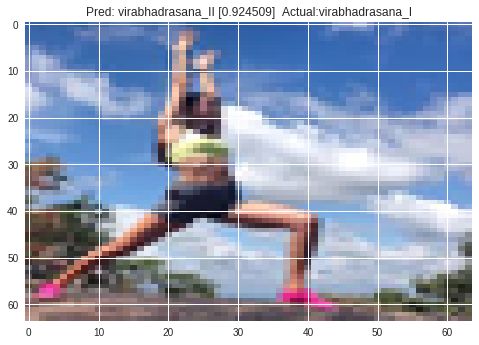

-------------------------------------------------------------------


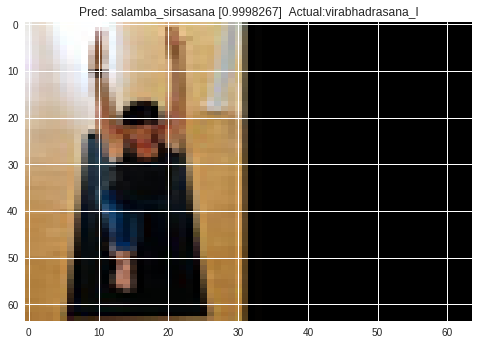

-------------------------------------------------------------------


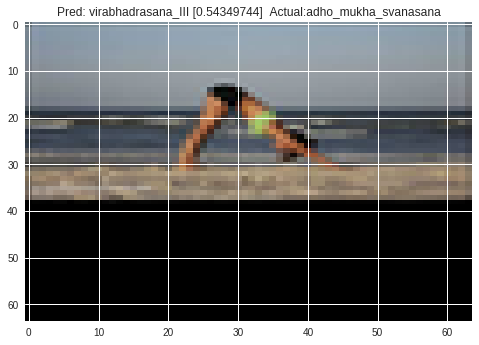

-------------------------------------------------------------------


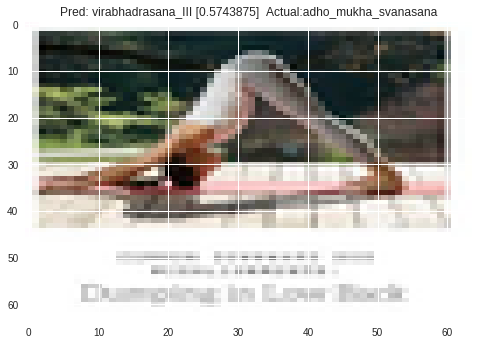

-------------------------------------------------------------------


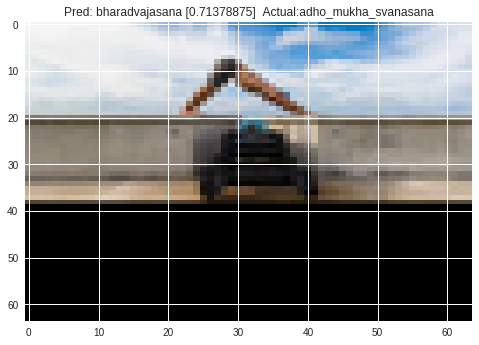

-------------------------------------------------------------------


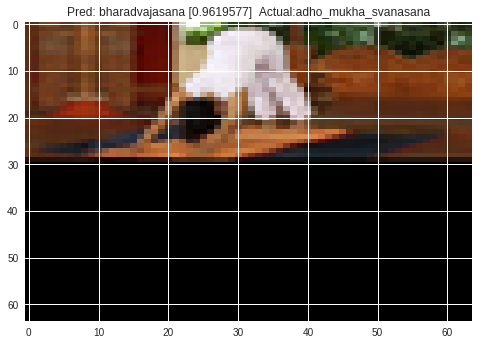

-------------------------------------------------------------------


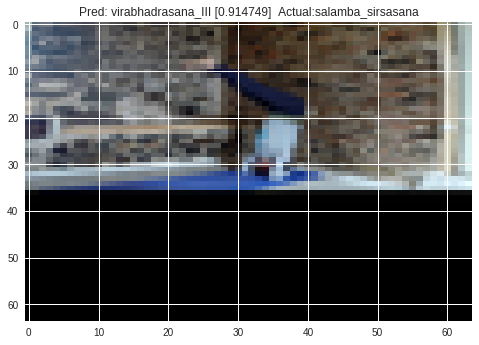

-------------------------------------------------------------------


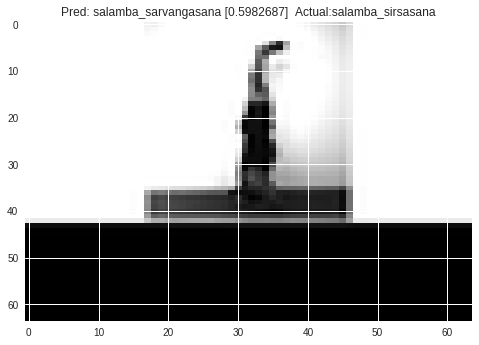

-------------------------------------------------------------------


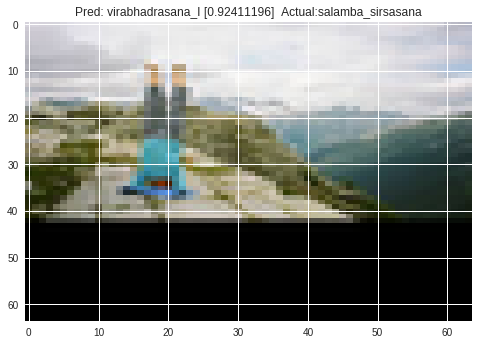

-------------------------------------------------------------------


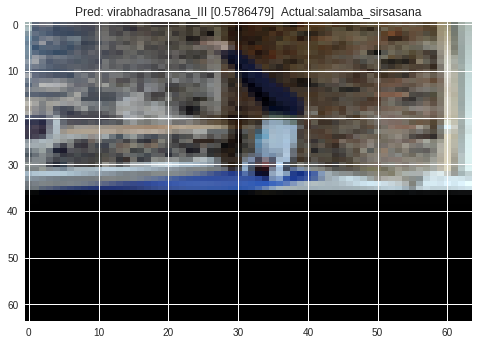

-------------------------------------------------------------------


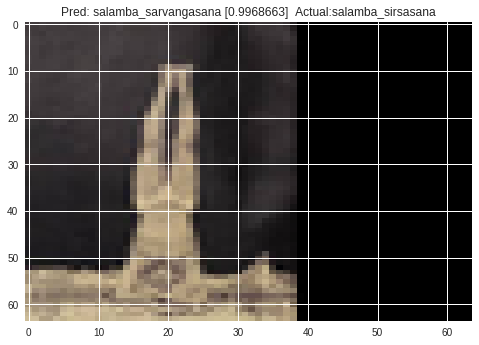

-------------------------------------------------------------------


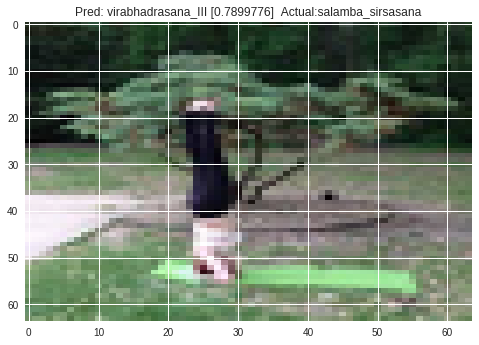

-------------------------------------------------------------------


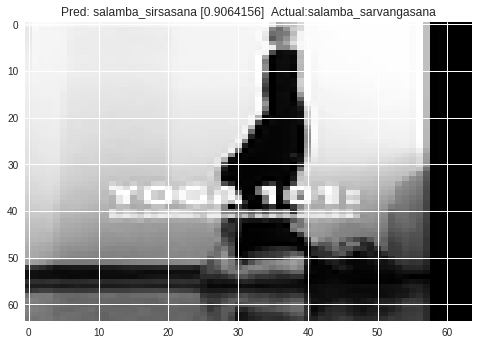

-------------------------------------------------------------------


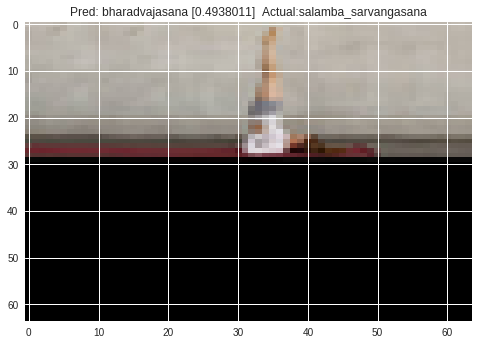

-------------------------------------------------------------------


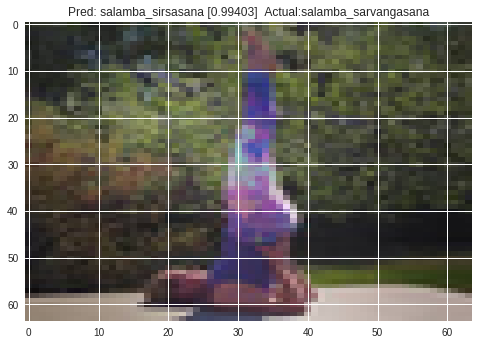

-------------------------------------------------------------------


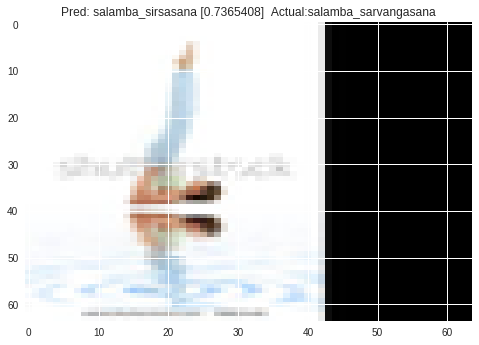

-------------------------------------------------------------------


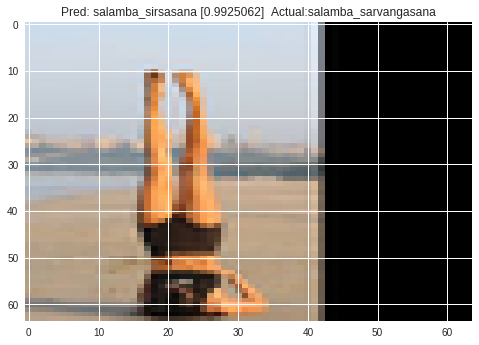

-------------------------------------------------------------------


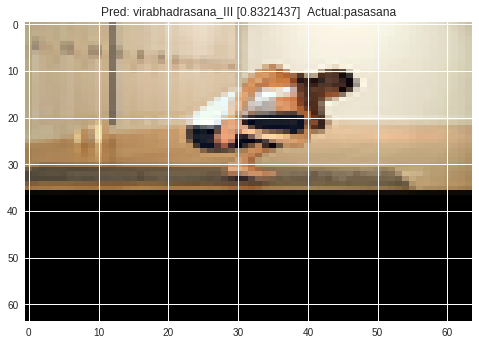

-------------------------------------------------------------------


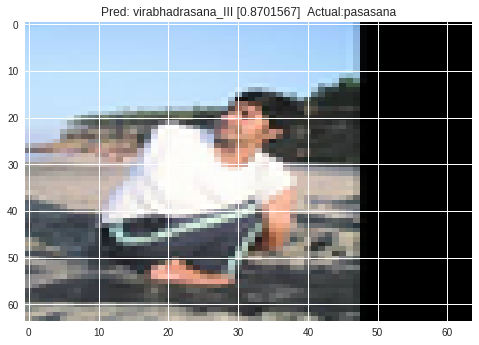

-------------------------------------------------------------------


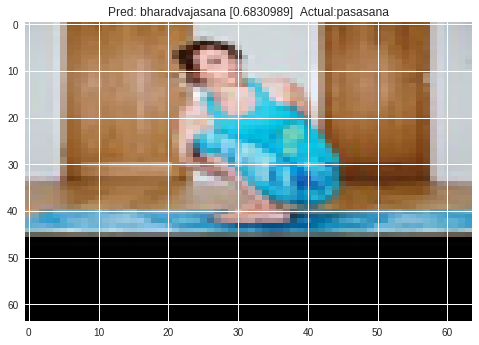

-------------------------------------------------------------------


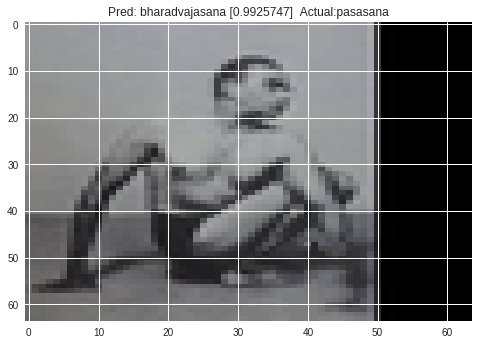

-------------------------------------------------------------------


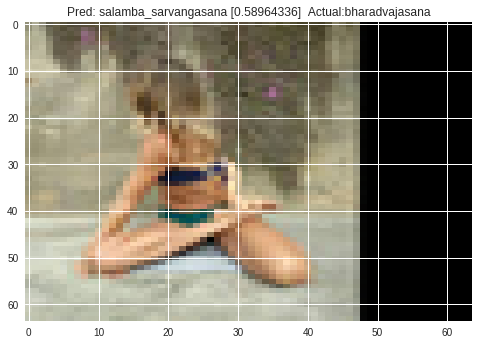

-------------------------------------------------------------------


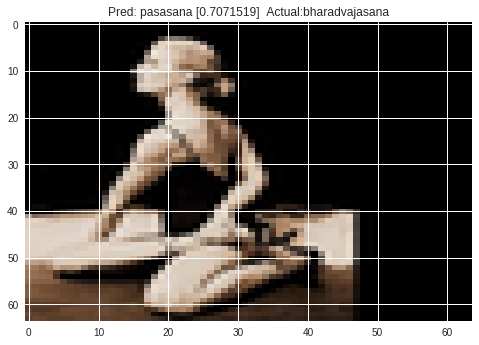

-------------------------------------------------------------------


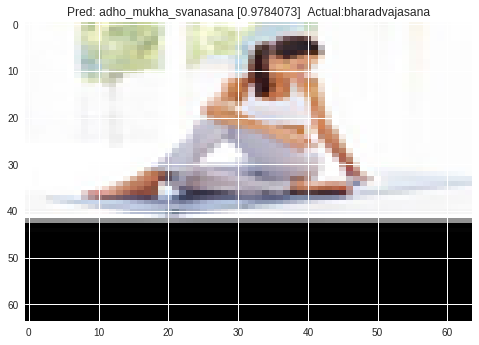

-------------------------------------------------------------------


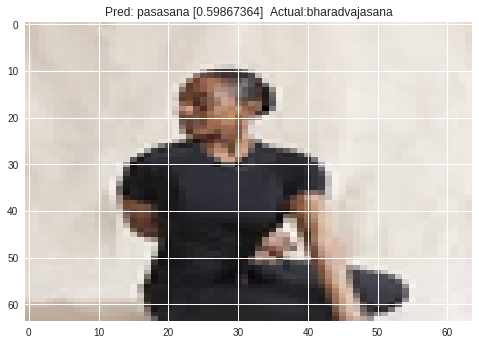

-------------------------------------------------------------------


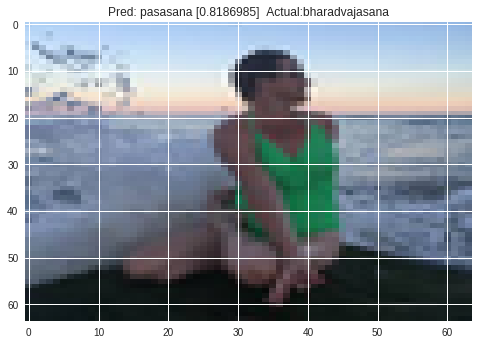

-------------------------------------------------------------------


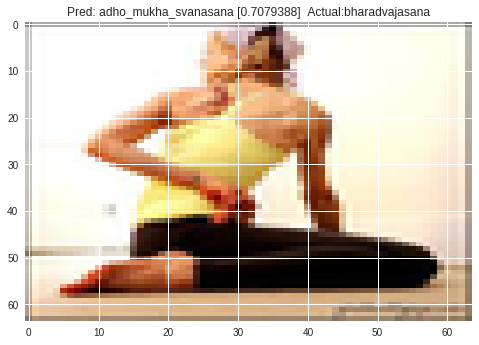

-------------------------------------------------------------------


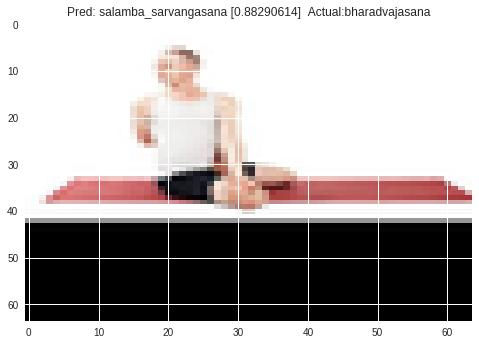

-------------------------------------------------------------------


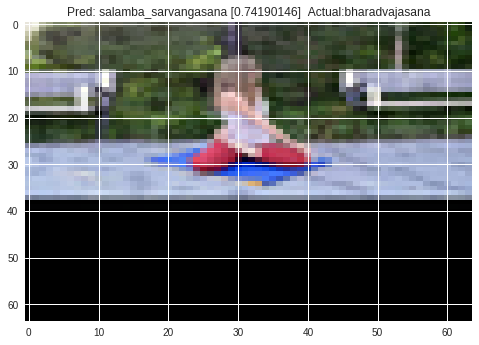

-------------------------------------------------------------------
Summary :
Average Prediction Accuracy :0.8641509433962264
Total Correct :229
Total Misclassifications :36
Total Prediction Time :6.046725749969482


In [0]:
test_images_and_labels = list(zip(X_test, Y_test))
#Predicting

correct_count = 0
wrong_count = 0
correct_indices = []
wrong_indices = []
preds = []
labels = []
total_predict_time = 0;
wrong_images = []
wrong_actuals = []
wrong_preds = []

import scipy.misc

for index,(image, label) in enumerate(test_images_and_labels):
    
    imagedata256 = image[np.newaxis, :, :]
    image64 = scipy.misc.imresize(image,(64,64))
    imagedata = image64[np.newaxis, :, :]
    
    #Record How Long Prediction Takes
    predict_start_time = time.time()
    pred = model.predict(imagedata)
    pred_prob = model.predict(imagedata)
    total_predict_time=total_predict_time+(time.time()-predict_start_time)
    
    #Process Predictions and Labels
    pred = pred[0].argmax(axis=0)
    label = label.argmax(axis=0)
    preds = np.append(preds,pred)
    labels = np.append(labels,label)
        
    if int(pred) == int(label) :
        correct_count=correct_count+1
        #correct_indices = np.append(correct_indices)
        #plt.imshow(imagedata256[0].astype('uint8'),aspect='auto')
        #plt.title("Pred: {pred} Actual:{label}".format(pred=str(label_pairs_reverse.get(pred))+" ["+str(np.amax(pred_prob))+"] ", label=label_pairs_reverse.get(label)))
        #plt.show()       
    else :
        wrong_count=wrong_count+1
        #wrong_indices = np.append(wrong_indices)
        np.append(wrong_images,imagedata256[0])
        np.append(wrong_actuals,label)
        np.append(wrong_preds,pred)
        plt.imshow(imagedata256[0].astype('uint8'),aspect='auto')
        plt.title("Pred: {pred} Actual:{label}".format(pred=str(label_pairs_reverse.get(pred))+" ["+str(np.amax(pred_prob))+"] ", label=label_pairs_reverse.get(label)))
        plt.show()
        print('-------------------------------------------------------------------')

mistakes = list(zip(wrong_actuals,wrong_preds,wrong_images))
accuracy=correct_count/(correct_count+wrong_count)

print('Summary :')
print('Average Prediction Accuracy :' + str(accuracy))
print('Total Correct :' + str(correct_count))
print('Total Misclassifications :' + str(wrong_count))
print("Total Prediction Time :" + str(total_predict_time))

In [0]:
print(preds)

[7. 7. 7. 7. 7. 7. 5. 7. 7. 7. 7. 7. 7. 7. 6. 7. 7. 3. 7. 7. 7. 7. 7. 7.
 7. 7. 7. 7. 7. 2. 7. 7. 7. 7. 7. 7. 7. 7. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 5. 8. 8. 8. 8. 8. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 6. 6. 6. 5. 6. 6. 6. 7. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 8. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 8. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 5. 5. 8. 5. 5. 4. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 6. 5. 5. 5. 5. 5. 5. 5. 5. 8. 5. 4. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 8. 5. 5. 4. 4. 4. 5. 2. 4. 5. 4. 4. 5. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 3. 3. 8. 8. 3. 3. 2. 3. 3. 3.
 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 4. 2. 3.
 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 1. 4. 2. 4.
 2.]


Confusion matrix, without normalization
[26 31 26 29 46 38 35 34]


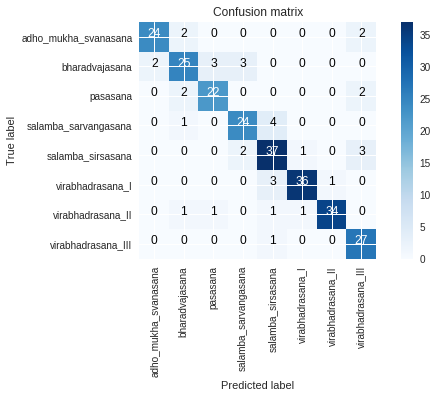

Normalized confusion matrix
[0.91774892 0.96672595 0.96337873 0.96500693 1.13542623 0.9495716
 0.91973684 1.1824048 ]


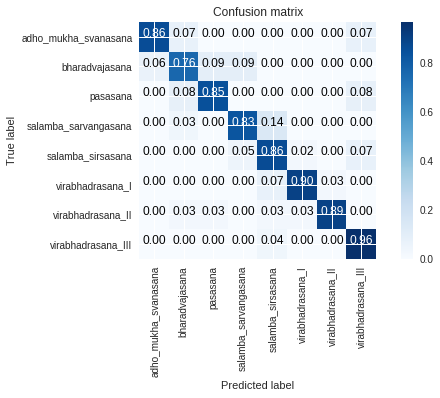

array([[24,  2,  0,  0,  0,  0,  0,  2],
       [ 2, 25,  3,  3,  0,  0,  0,  0],
       [ 0,  2, 22,  0,  0,  0,  0,  2],
       [ 0,  1,  0, 24,  4,  0,  0,  0],
       [ 0,  0,  0,  2, 37,  1,  0,  3],
       [ 0,  0,  0,  0,  3, 36,  1,  0],
       [ 0,  1,  1,  0,  1,  1, 34,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 27]])

In [0]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
conf_mat = np.matrix(tf.confusion_matrix(labels,preds,num_classes=8,dtype=tf.int32))
conf_mat = confusion_matrix(labels,preds)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
        #print('Confusion matrix, without normalization')

    print(sum(cm))
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
class_nums=[1,2,3,4,5,6,7,8]
class_names=[]
for num in class_nums:
  class_names.append(label_pairs_reverse.get(num))
np.set_printoptions(threshold=np.nan)

# Plot non-normalized confusion matrix
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names)
plt.show()
conf_mat

# Plot normalized confusion matrix
print("Normalized confusion matrix")
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True)
plt.show()

(conf_mat)



In [0]:
print(len([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7.]))

38


In [0]:
np.shape(np.column_stack((preds,labels)))

(265, 2)

In [0]:
np.savetxt('test.csv',np.column_stack((preds,labels)),delimiter=",")


In [0]:
def authenticateWithGDrive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)
def uploadFileToGoogleDrive(local_file_dir,name,parentfolder_id):
  file=drive.CreateFile({'title': name,'parents':[{"kind": "drive#fileLink", "id": parentfolder_id}]})
  file.SetContentFile(local_file_dir)
  file.Upload()
  return file.get('id')

In [0]:
uploadFileToGoogleDrive('test.csv',model_name+'_test.csv','1vQhQXjy4X9woILOTXeY3C-tz14xJkBQE')

'1Ffk5mcwWh7WgaySRssXTk-YWpXr_sPc3'

In [0]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)

    

In [0]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [0]:
 layer=tflearn.variables.get_layer_variables_by_name("GlobalAvgPool")

In [0]:
print(X_test[0])

In [0]:
 m2 = tflearn.DNN(network, session=model.session)


AssertionError: ignored

In [0]:
import tensorflow as tf
sess = tf.Session()
getActivations(layer,X_test[0])

NameError: ignored